In [1]:
import pandas as pd
import re
import json
import codecs
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
# Функция предобработки исходного текста
def preprocess(text:str):
    result = re.sub(r'[\.\?\!\,\:\;\"]', '', text.lower())
    tokenized = word_tokenize(result)

    stop_words = set(stopwords.words('russian')) 
    statement_no_stop = [word for word in tokenized if word not in stop_words]

    return ' '.join(statement_no_stop)

In [3]:
preprocess('В городке около стадиона бродячих собак тоже очень много бегают.')

'городке около стадиона бродячих собак очень бегают'

In [4]:
# Чтение данных из json
f = codecs.open('intents.json', "r", "utf_8_sig")

data = json.load(f)

print(data)

{'intents': {'Безопасность': ['В городке около стадиона бродячих собак тоже очень много бегают.', 'Здравствуйте. Администрация города отвечает за безопасность людей живущих там. Но не девочки. Своры бездомных животных, это бездействие власти.', 'В Благовещенске участились случаи нападения бродячих собак Сегодня читатели сообщили о том, что в Моховой Пади обострилась ситуация с бродячими собаками. Они рассказывают о двух фактах нападений, в результате которых есть пострадавшие. В частности, жители дома ДОС-23 в Моховой Пади сообщают, что вчера на территории школы № 23 были покусаны двое детей, один из которых обратился за медицинской помощью и вакцинацией от бешенства. Ещё двое детей пострадали от www.amur.info', 'В Советском посёлке в сопках живёт стая собак, мы насчитали штук 10,сегодня ехали с работы, две собаки накинулись на машину, а если идти пешком, в прошлом году они разорвали соседского кота, они периодически у нас в посёлке появляются, а сейчас по моему у них логово в сопках, 

In [5]:
# Преобразование в датасет
dataset = []

for intent, intent_value in data['intents'].items():
    print('{}: {}'.format(intent, len(intent_value)))
    for example in intent_value:
        dataset.append([preprocess(example), intent])

print('example: ', dataset[0])
print('total:', len(dataset))


Безопасность: 456
Дороги и тратуары: 448
ЖКХ: 448
Коронавирус: 301
Мусор и свалки: 330
Экология: 105
example:  ['городке около стадиона бродячих собак очень бегают', 'Безопасность']
total: 2088


In [6]:
# Векторизация
corpus = [example for example, _ in dataset]
labels = [intent for _, intent in dataset]
print('labels size:', len(set(labels)))

count_vectorizer = CountVectorizer()
tfid_word_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfid_char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4,6))
tfid_char_wb_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(4,6))

features_list = [
    ('CountVectorizer', count_vectorizer.fit_transform(corpus)),
    ('TfidfWordVectorizer', tfid_word_vectorizer.fit_transform(corpus)),
    ('TfidfCharVectorizer', tfid_char_vectorizer.fit_transform(corpus)),
    ('TfidfCharWbVectorizer', tfid_char_wb_vectorizer.fit_transform(corpus)),
]

labels size: 6


In [7]:
models = [
  MultinomialNB(),
  LogisticRegression(random_state=0),
  PassiveAggressiveClassifier(),
  SVC(),
  LinearSVC(dual='auto', class_weight='balanced'),
  DecisionTreeClassifier(random_state=0)
]

In [9]:
CV = 5
entries = []
for vectorizer_idx, (vectorizer_name, features) in enumerate(features_list):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.2,
                                                    random_state=0)
  for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
      entries.append((vectorizer_idx, model_name, fold_idx, accuracy))

Text(0.5, 1.0, 'Model and Vectorizer')

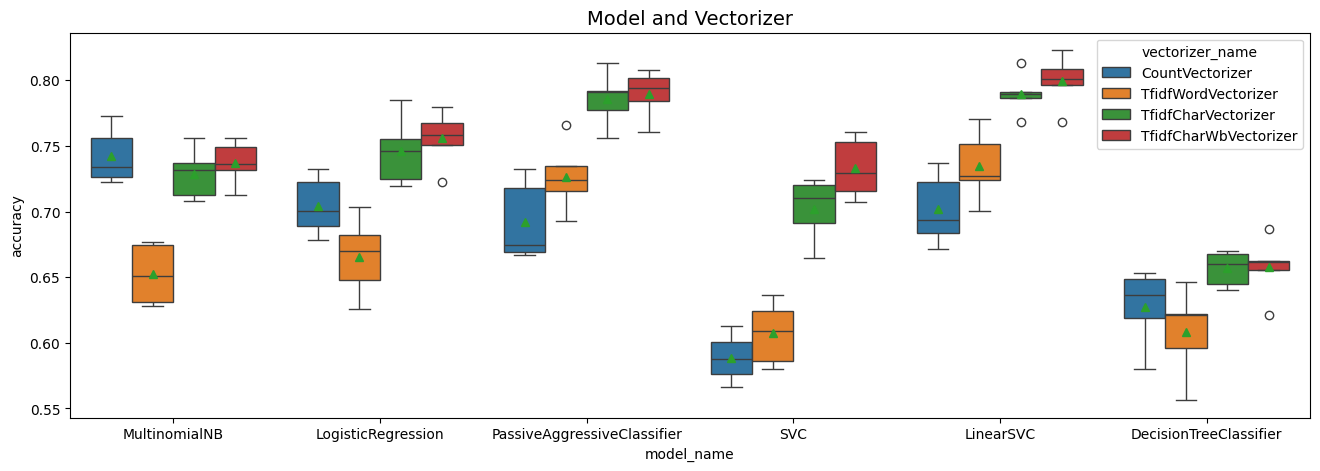

In [17]:
# Сравнение различных моделей
cv_df = pd.DataFrame(entries, columns=['vectorizer_name', 'model_name', 'fold_idx', 'accuracy'])
mean_accuracy = cv_df.groupby(['vectorizer_name', 'model_name']).accuracy.mean()
std_accuracy = cv_df.groupby(['vectorizer_name', 'model_name']).accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']

cv_df.replace({0:'CountVectorizer', 
               1:'TfidfWordVectorizer',
               2:'TfidfCharVectorizer',
               3:'TfidfCharWbVectorizer'}, inplace=True)

plt.figure(figsize=(16,5))
sns.boxplot(x='model_name', y='accuracy', hue='vectorizer_name',
            data=cv_df,
            showmeans=True)
plt.title('Model and Vectorizer', size=14)

In [23]:
plt.figure(figsize=(15,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14)

Text(0.5, 1.0, 'MEAN ACCURACY (cv = 5)\n')

In [8]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(4,6))
features = vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, random_state=1)

In [9]:
model = LinearSVC(dual='auto', class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [11]:
# Classification report
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= set(labels)))

                   precision    recall  f1-score   support

      Коронавирус       0.79      0.81      0.80        93
     Безопасность       0.81      0.86      0.84        77
Дороги и тратуары       0.78      0.83      0.80        94
   Мусор и свалки       0.91      0.95      0.93        64
              ЖКХ       0.89      0.83      0.86        71
         Экология       0.89      0.42      0.57        19

         accuracy                           0.83       418
        macro avg       0.85      0.78      0.80       418
     weighted avg       0.83      0.83      0.83       418



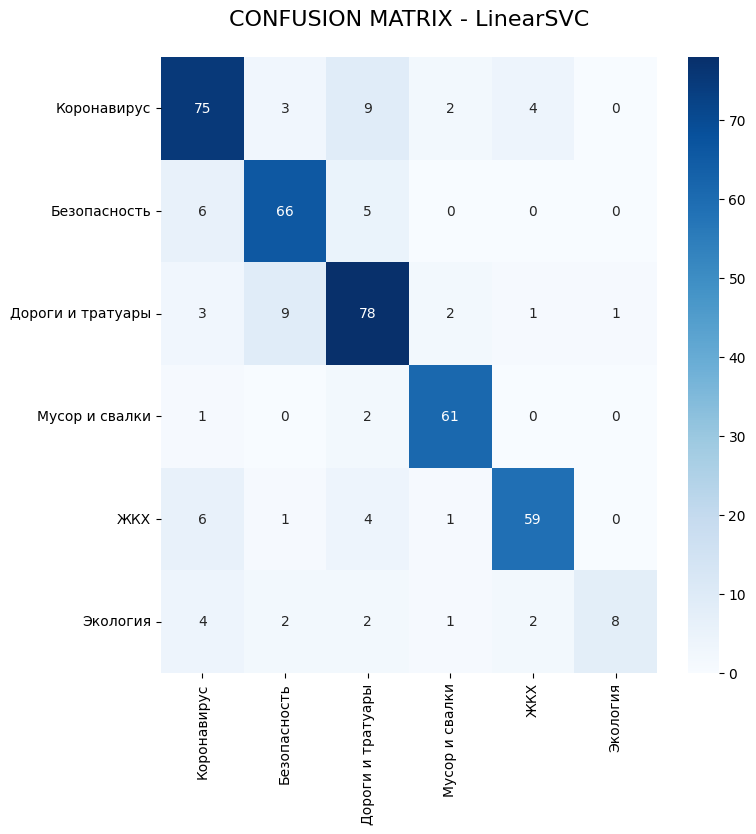

In [12]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=set(labels), 
            yticklabels=set(labels))
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);